In [2]:
%load_ext cython

import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io
from os import listdir
from os.path import isfile, join

sys.path.append("../src/")
from sarra_py import *

In [3]:
date_start = datetime.date(2022,1,1)
duration = 180

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# Loading TAMSAT rainfall data

In [4]:
# loading TAMSAT rainfall data
TAMSAT_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/TAMSAT_v3.1_burkina_rfe_filled"
TAMSAT_files = [f for f in listdir(TAMSAT_path) if isfile(join(TAMSAT_path, f))]

TAMSAT_files_df = pd.DataFrame({"filename":TAMSAT_files})

TAMSAT_files_df["date"] = TAMSAT_files_df.apply(
    lambda x: datetime.date(
        int(x["filename"].replace(".tif","").split("_")[-3]),
        int(x["filename"].replace(".tif","").split("_")[-2]),
        int(x["filename"].replace(".tif","").split("_")[-1]),
    ),
    axis=1,
)

TAMSAT_files_df = TAMSAT_files_df[(TAMSAT_files_df["date"]>=date_start) & (TAMSAT_files_df["date"]<date_start+datetime.timedelta(days=duration))]
TAMSAT_files_df

,filename,date
0,TAMSAT_v3.1_burkina_rfe_filled_2022_01_01.tif,2022-01-01
1,TAMSAT_v3.1_burkina_rfe_filled_2022_01_02.tif,2022-01-02
2,TAMSAT_v3.1_burkina_rfe_filled_2022_01_03.tif,2022-01-03
3,TAMSAT_v3.1_burkina_rfe_filled_2022_01_04.tif,2022-01-04
4,TAMSAT_v3.1_burkina_rfe_filled_2022_01_05.tif,2022-01-05
...,...,...
175,TAMSAT_v3.1_burkina_rfe_filled_2022_06_25.tif,2022-06-25
176,TAMSAT_v3.1_burkina_rfe_filled_2022_06_26.tif,2022-06-26
177,TAMSAT_v3.1_burkina_rfe_filled_2022_06_27.tif,2022-06-27
178,TAMSAT_v3.1_burkina_rfe_filled_2022_06_28.tif,2022-06-28


In [5]:
import rasterio
src = rasterio.open(os.path.join(TAMSAT_path,TAMSAT_files_df.loc[0,"filename"]))
array = src.read(1)

# rainfall grid size defines output resolution
grid_width = array.shape[0]
grid_height = array.shape[1]

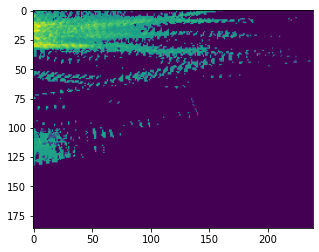

In [6]:
from matplotlib import pyplot
pyplot.imshow(array, cmap='viridis')

# Loading AgERA5 weather data

In [7]:
AgERA5_data_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/AgERA5_burkina/"
AgERA5_variables = [path.split("/")[-1] for path in [x[0] for x in os.walk(AgERA5_data_path)][1:]]

# defining dict of dfs, one df per variable
AgERA5_files_df_collection = {}
for variable in AgERA5_variables:
    AgERA5_files = [f for f in listdir(os.path.join(AgERA5_data_path,variable)) if isfile(join(os.path.join(AgERA5_data_path,variable), f))]
    AgERA5_files_df_collection[variable] = pd.DataFrame({"filename":AgERA5_files})

    
    AgERA5_files_df_collection[variable]["date"] = AgERA5_files_df_collection[variable].apply(
        lambda x: datetime.date(
            int(x["filename"].replace(".tif","").split("_")[-3]),
            int(x["filename"].replace(".tif","").split("_")[-2]),
            int(x["filename"].replace(".tif","").split("_")[-1]),
        ),
        axis=1,
    )

    AgERA5_files_df_collection[variable] = AgERA5_files_df_collection[variable][(AgERA5_files_df_collection[variable]["date"]>=date_start) & (AgERA5_files_df_collection[variable]["date"]<date_start+datetime.timedelta(days=duration))]

# Feeding these datasets into the numpy matrices

In [8]:
import numpy as np

data = {}

# rain
data["rain"] = np.empty((grid_width, grid_height, duration))
for i in range(duration):
    dataset = rasterio.open(os.path.join(TAMSAT_path,TAMSAT_files_df.loc[i,"filename"]))
    data["rain"][:,:,i] = dataset.read(1)
    dataset.close()



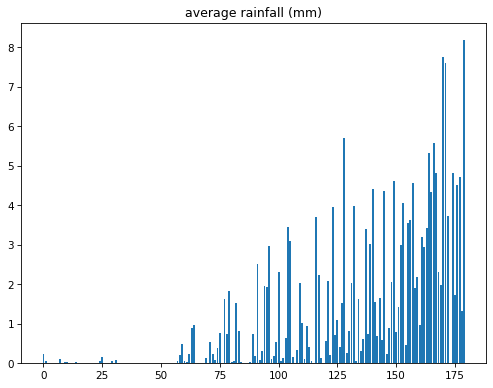

In [9]:
from matplotlib.pyplot import figure
# plotting rain for verif purpose
plot_value_mean = data["rain"].mean(axis=(0,1))
figure(figsize=(8, 6), dpi=75)
plt.bar(range(duration),plot_value_mean)
plt.title("average rainfall (mm)")
plt.show()

In [10]:
from rasterio.enums import Resampling

AgERA5_SARRA_correspondance = {
    '10m_wind_speed_24_hour_mean':None,
    '2m_temperature_24_hour_maximum':None,
    '2m_temperature_24_hour_mean':'tpMoy',
    '2m_temperature_24_hour_minimum':None,
    'ET0Hargeaves':'ET0',
    'solar_radiation_flux_daily':'rg',
    'vapour_pressure_24_hour_mean':None,
}

resampling_method = "nearest"

for variable in tqdm(AgERA5_variables) :
    if AgERA5_SARRA_correspondance[variable] != None :

        data[AgERA5_SARRA_correspondance[variable]] = np.empty((grid_width, grid_height, duration))

        for i in tqdm(range(duration), leave=False, desc="variable {variable}") :
            dataset = rasterio.open(os.path.join(AgERA5_data_path,variable,AgERA5_files_df_collection[variable].loc[i,"filename"]))

            arr = dataset.read(
                    out_shape=(
                        dataset.count,
                        grid_width,
                        grid_height,
                    ),
                    resampling=getattr(Resampling, resampling_method)
                )[0]

            data[AgERA5_SARRA_correspondance[variable]][:,:,i] = arr
            dataset.close()

# correcting rg
data["rg"] = data["rg"]/1000

# default irrigation scheme 
data["irrigation"] = np.empty((grid_width, grid_height, duration))

100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


In [11]:
data.keys()

dict_keys(['rain', 'tpMoy', 'ET0', 'rg', 'irrigation'])

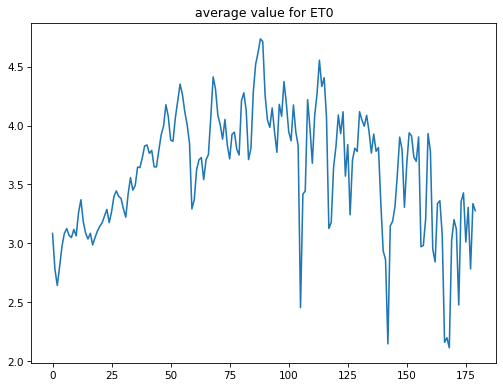

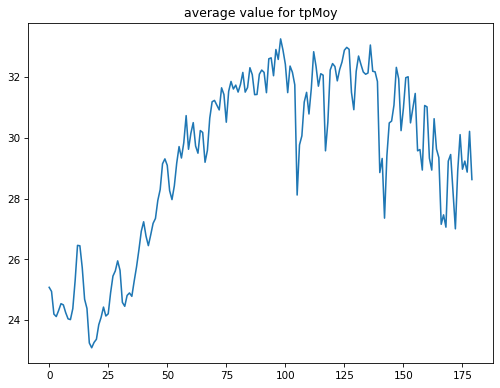

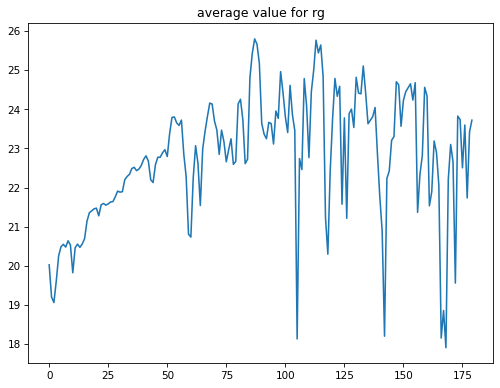

In [12]:
from matplotlib.pyplot import figure
for variable in ["ET0","tpMoy","rg"]:
    # plotting rain for verif purpose
    plot_value_mean = data[variable].mean(axis=(0,1))
    figure(figsize=(8, 6), dpi=75)
    plt.plot(plot_value_mean)
    plt.title("average value for "+variable)
    plt.show()

In [13]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0

In [14]:
# Read YAML file
with open(os.path.join('../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()

with open(os.path.join('../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

# alt : construction de grilles climatiques

# Run

In [15]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

In [17]:
import warnings
warnings.filterwarnings("ignore")

# data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, paramTypeSol, paramITK)

# on débraye initsup2 car les données MTO sont chargées
# data = InitSup2(data, grid_width, grid_height, duration, df_weather)

# variables = {"tpMoy":"TEMP", "rain":"RAIN", "ET0":"ET0", "rg":"IRRAD"}
# for variable in variables:
#     print(variable)
#     data[variable] = np.empty((grid_width, grid_height, duration))
#     data[variable][:] = np.nan

#     for lon in range(grid_width):
#         for lat in range(grid_height):
#             try:
#                 data[variable][lat, lon, :] = weather_country.loc[(weather_country["LON"] == weather_country["LON"].unique()[lon]) & (weather_country["LAT"] == weather_country["LAT"].unique()[lat]), variables[variable]].values
#             except:
#                 pass


data = EvalPar(data)

for j in tqdm(range(duration)):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    # print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


100%|██████████| 180/180 [06:25<00:00,  2.14s/it]


In [ ]:
for variable in data.keys() :
    plot_value_mean = data[variable].mean(axis=(0,1))
    plt.plot(plot_value_mean)
    plt.title(variable)
    plt.show()

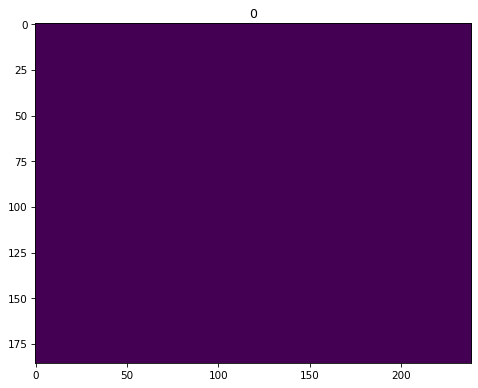

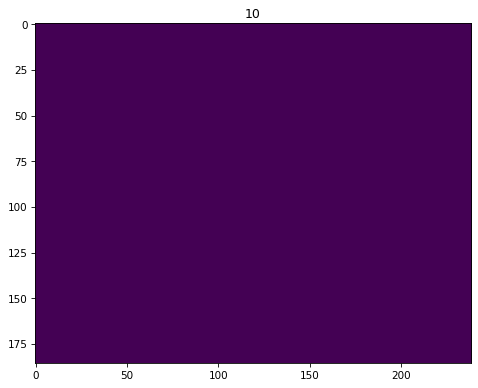

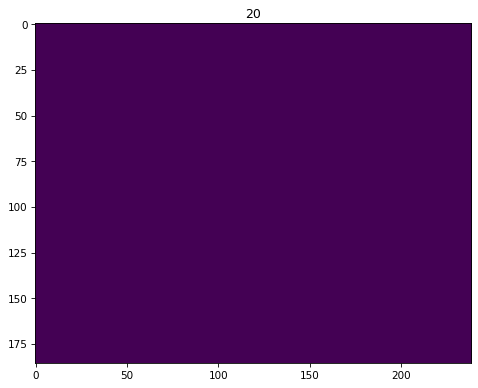

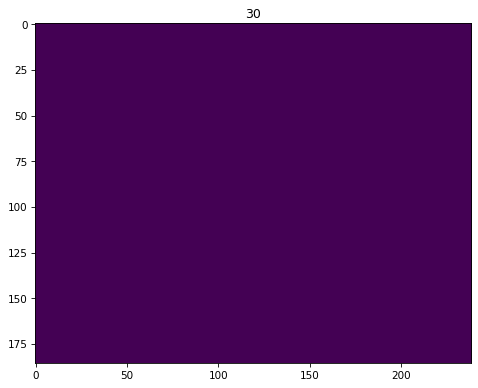

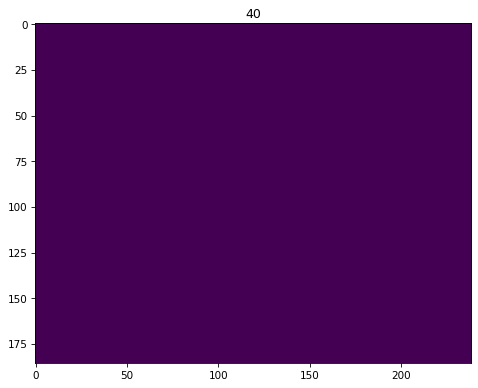

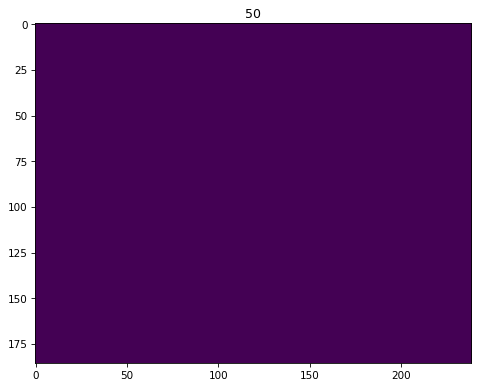

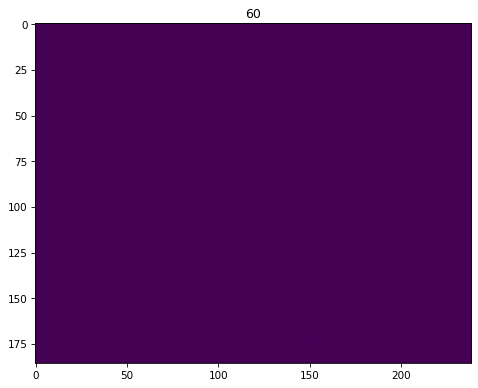

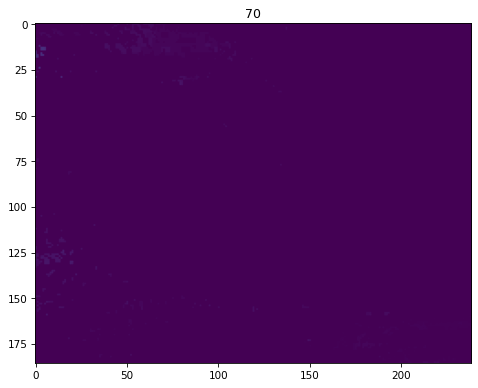

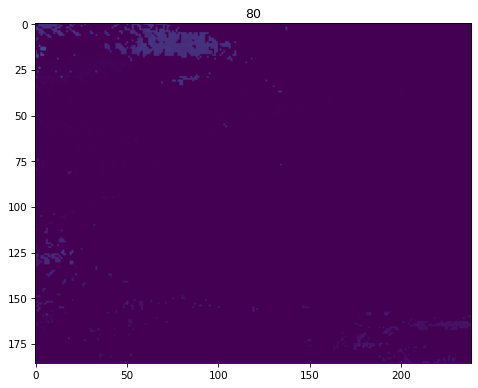

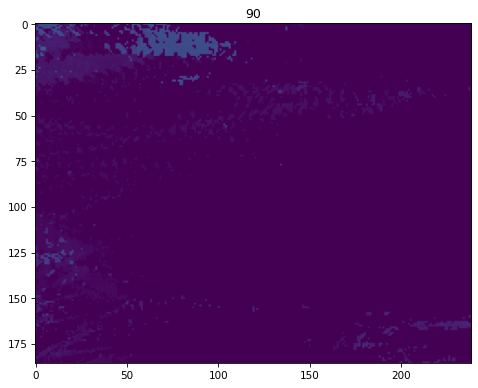

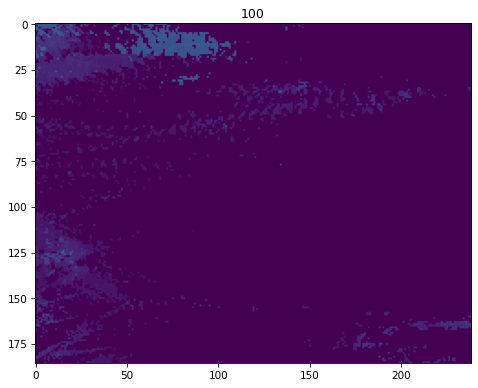

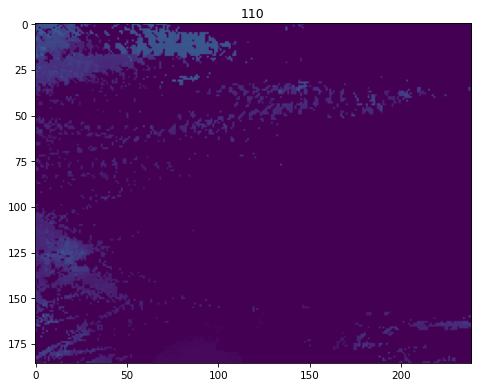

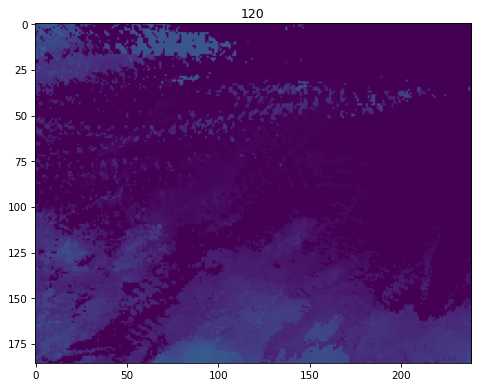

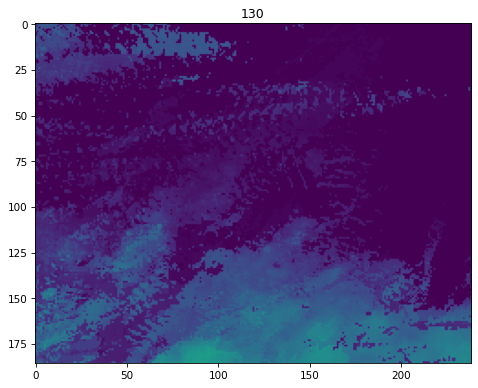

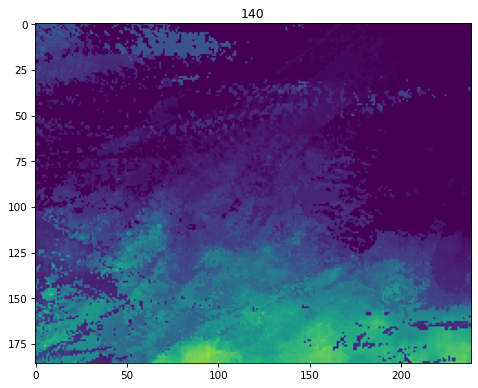

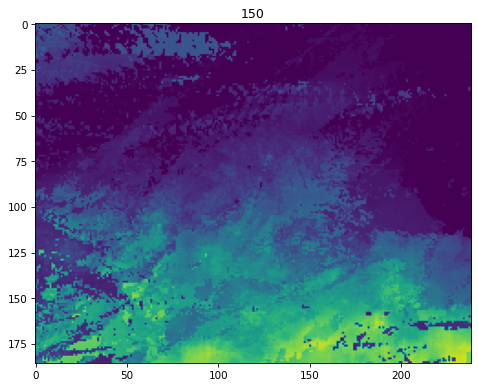

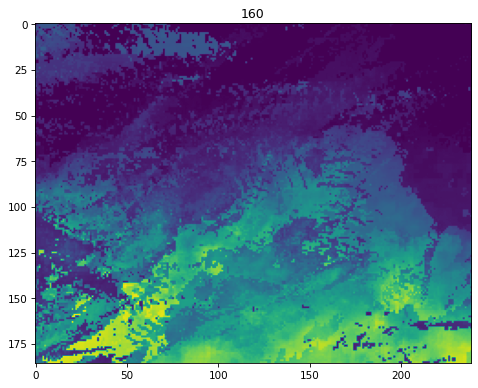

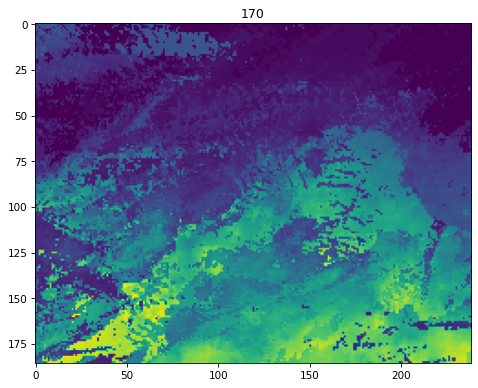

In [19]:
variable = "rdt"
for i in range(int(duration/10)):
    figure(figsize=(8, 6), dpi=75)
    plt.imshow(data[variable][:,:,int(i*10)], vmin=0, vmax=np.max(data[variable]))
    plt.title(i*10)
    plt.show()

In [ ]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
df_gt = pd.read_csv("../data/simu_AG3US20124.txt", sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

df_gt

,Jour,NbJas,NumPhase,DegresDuJour,Lai,FTSW,Cstr,Eto,ETM,ETR,...,Conversion,StockTotal,BiomMc,StockMc,LitFeuilles,LitTiges,FeuillesUp,TigesUp,Hum,EToCO2
0,2012-04-01,-27,NaN,NaN,NaN,0.000000,0.000000,3.179907,3.179907,0.000000,...,0.0,170.000000,0,0,0,0,0.000000,0.000000,170.0000,3.179907
1,2012-04-02,-26,NaN,NaN,NaN,0.000000,0.000000,3.950088,3.950088,3.950088,...,0.0,193.409912,0,0,0,0,0.000000,0.000000,197.3600,3.950088
2,2012-04-03,-25,NaN,NaN,NaN,0.000000,0.000000,3.642551,3.642551,2.719009,...,0.0,190.690903,0,0,0,0,0.000000,0.000000,197.3600,3.642551
3,2012-04-04,-24,NaN,NaN,NaN,0.000000,0.000000,4.539865,4.539865,2.694119,...,0.0,187.996784,0,0,0,0,0.000000,0.000000,197.3600,4.539865
4,2012-04-05,-23,NaN,NaN,NaN,0.000000,0.000000,4.661987,4.661987,2.140356,...,0.0,185.856428,0,0,0,0,0.000000,0.000000,197.3600,4.661987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2012-12-06,222,0.0,0.0,0.0,0.403482,0.684381,0.896016,0.488544,0.233363,...,0.0,131.586473,0,0,0,0,767.283559,9321.376757,140.7892,0.896016
250,2012-12-07,223,0.0,0.0,0.0,0.403482,0.684381,0.998676,0.544519,0.254088,...,0.0,131.332385,0,0,0,0,767.283559,9321.376757,140.7892,0.998676
251,2012-12-08,224,0.0,0.0,0.0,0.403482,0.684381,0.610870,0.333071,0.172241,...,0.0,132.460144,0,0,0,0,767.283559,9321.376757,140.7892,0.610870
252,2012-12-09,225,0.0,0.0,0.0,0.403482,0.684381,0.435127,0.237249,0.162192,...,0.0,135.597952,0,0,0,0,767.283559,9321.376757,140.7892,0.435127


In [ ]:
def graph_comparison(var_gt, var_sim):


    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.rcParams["figure.autolayout"] = True

    # ax1 = plt.subplot()
    # l1, = ax1.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label="sim")

    # ax2 = ax1.twinx()
    # l2, = ax2.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label="sarrah")

    plt.plot(df_weather["Jour"], data["numPhase"][0,0,:], label="numPhase", alpha=0.5)
    plt.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label=var_sim+" (sim)")
    plt.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label=var_gt+" (sarrah)")
    

    # plt.vlines(date,
    #     np.nanmin(np.nanmin(data[var_sim][0,0,:]),np.nanmin(df_gt[var_gt])), 
    #     np.nanmax(np.nanmin(data[var_sim][0,0,:]),np.nanmax(df_gt[var_gt])),
    # )

    #plt.vlines(date,0,100)

    #plt.legend([l1, l2], [var_sim+" (sim)", var_gt+" (sarrah)"])
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def compute_earliest_diff(var_gt, var_sim, tol=10E-6):
    try:
        #tol = 0.0001
        df_gt_2 = df_gt
        df_gt_2 = df_gt_2.merge(pd.DataFrame({"Jour":df_weather["Jour"],var_sim:data[var_sim][0,0,:]}), left_on="Jour", right_on="Jour")
        df_gt_2["delta"] = np.abs(df_gt_2[var_sim] - df_gt_2[var_gt])
        #df_gt_2 = df_gt_2.dropna()
        df_gt_2["signif"] = False
        # df_gt_2["signif"] = df_gt_2.apply(lambda x: np.divide(x["delta"],x[var_gt])>tol, axis=1)
        df_gt_2["signif"] = df_gt_2.apply(lambda x: x["delta"]>tol, axis=1)
        if np.nansum(df_gt_2["signif"]) == 0.0:
            earliest=datetime.date(1990,1,1)
        else:
            earliest = df_gt_2.loc[df_gt_2["signif"]==True,"Jour"].values[0]
        meandiff = np.nanmean(df_gt_2["delta"])
    except:
        earliest,meandiff = np.nan,np.nan
    return earliest,meandiff

In [ ]:
var_correspondance = {
    'DegresDuJour':"ddj",
    'Lai':"lai",
    'FTSW':"ftsw",
    'Cstr':"cstr",
    'Eto':"ET0",
    'ETM':"etm",
    'ETR':"etr",
    'Sla':"sla",
    'Assim':"assim",
    # 'DayLength',
    'Par':'par',
    # 'RgCalc',
    # 'VDPCalc',
    'TMoyCalc':"tpMoy",
    # 'HMoyCalc',
    'EauDispo':'eauDispo',
    'StockSurface':"stRuSurf",
    'StockRac':"stRur",

    'RURac':'stRurMax',
    'Kcp':'kcp',
    'Kce':"kce",
    'EvapPot':'evapPot',
    'Evap':"evap",
    'TrPot':"trPot",
    'Tr':"tr",
    'Lr':'lr',
    'Dr':'dr',
    'SumDegresDay':"sdj",
    'BiomasseTotale':"biomasseTotale",
    'BiomasseAerienne':'biomasseAerienne',
    'BiomasseFeuilles':"biomasseFeuille",
    'BiomasseTiges':"biomasseTige",
    'BiomasseVegetative':"biomasseVegetative",
    'BiomasseRacinaire':"biomasseRacinaire",
    'Rdt':"rdt",
    'VitesseRacinaire':"vRac",
    'FESW':"fesw",
    'Kc':"kcTot",
    'Ltr':'ltr',
    'DRespMaint':'respMaint',
    'DBiomTot':"deltaBiomasseTotale",
    'DRdtPot':"dRdtPot", 
    'Reallocation':'reallocation',
    'RdtPot':'rdtPot',
    # 'RayExtra',
    # 'SumDDPhasePrec',
    # 'SeuilTemp',
    # 'TMinMoy',
    # 'TMaxMoy',
    # 'FtswMoy',
    'IrrigTotDay':'irrigTotDay',
    'Conversion':'conv',
    'StockTotal':'stTot',
    'BiomMc':'biomMc',
    'StockMc':'stockMc',
    'LitFeuilles':"litFeuilles",
    'LitTiges':"litTiges",
    'FeuillesUp':"feuillesUp",
    'TigesUp':"tigesUp",
    'Hum':"hum",
    #'EToCO2',
}

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


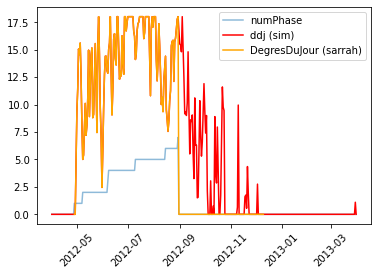

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


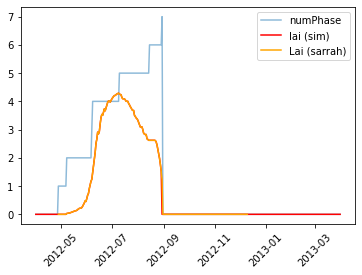

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


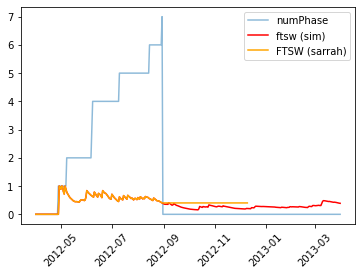

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


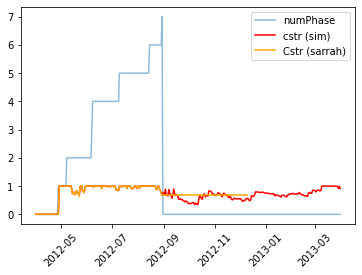

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


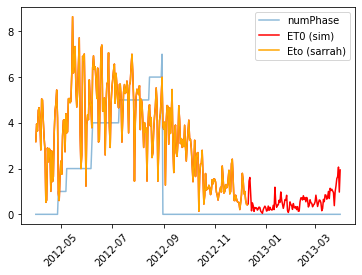

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


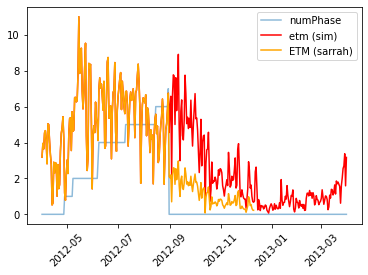

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


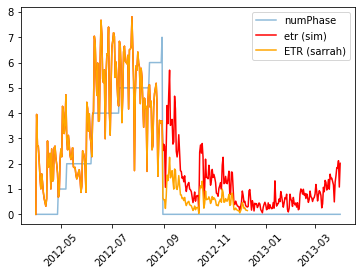

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


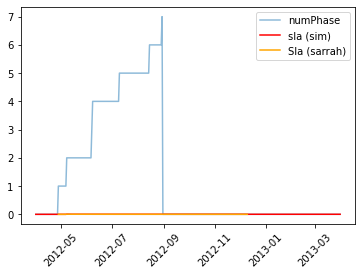

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


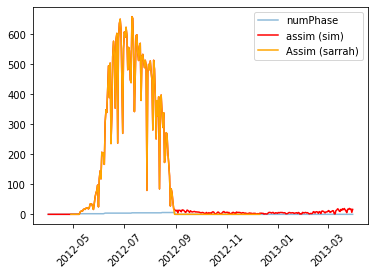

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


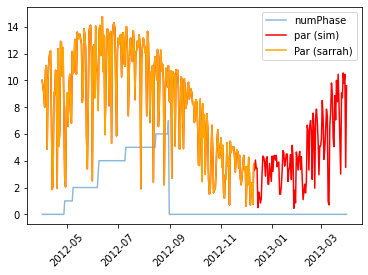

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


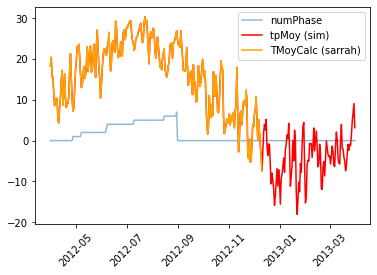

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


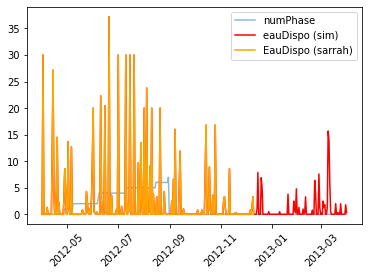

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


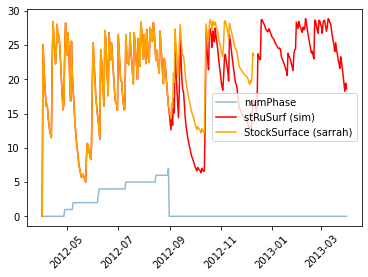

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


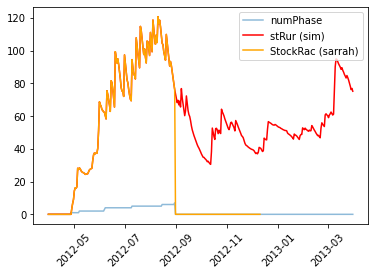

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


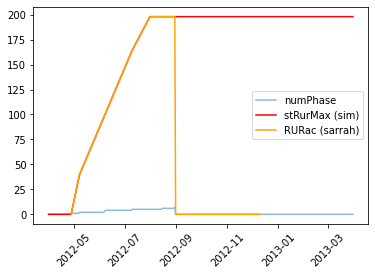

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


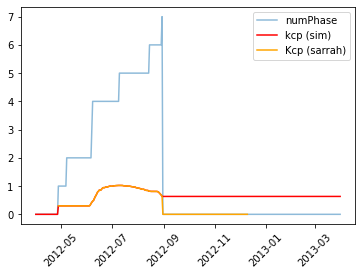

2012-09-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


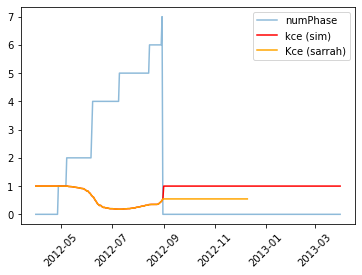

2012-09-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


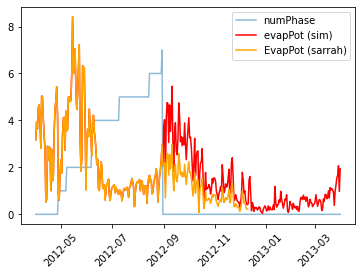

2012-09-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


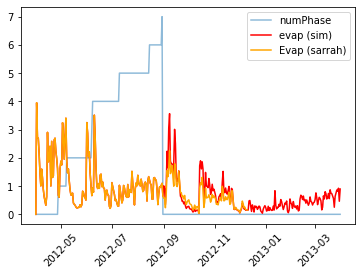

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


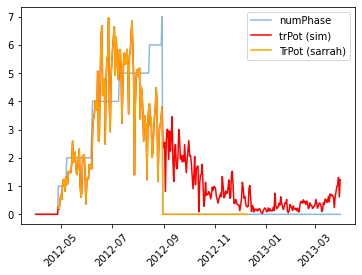

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


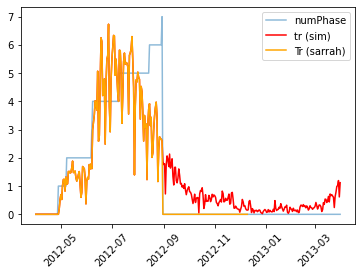

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


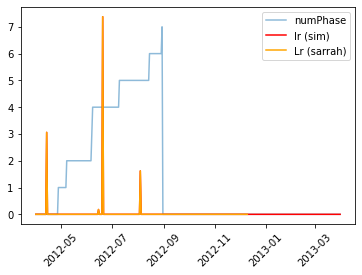

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


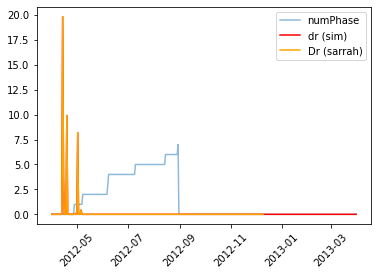

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


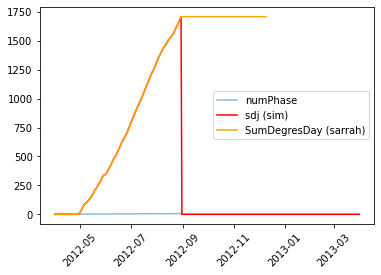

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


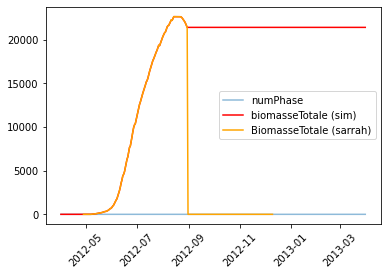

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


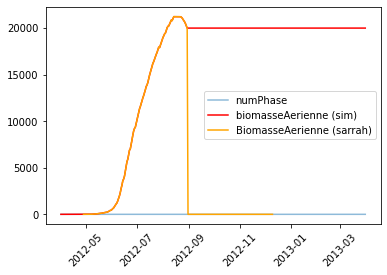

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


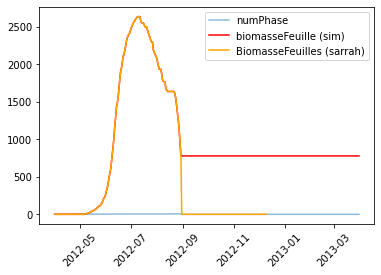

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


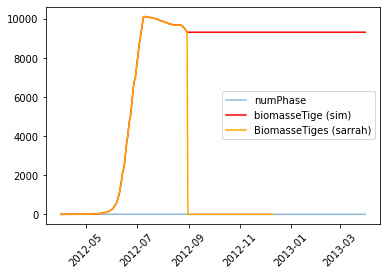

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


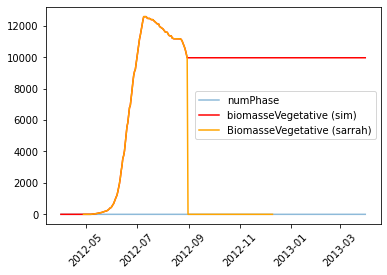

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


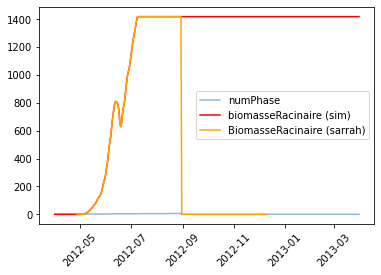

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


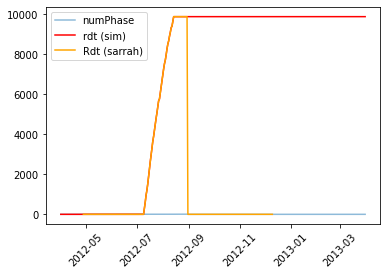

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


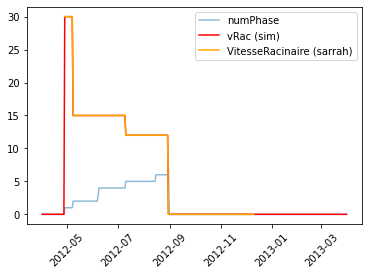

2012-09-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


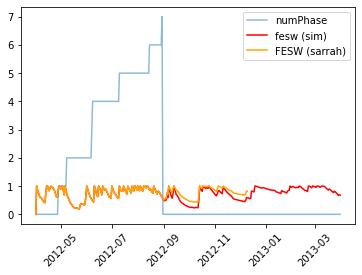

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


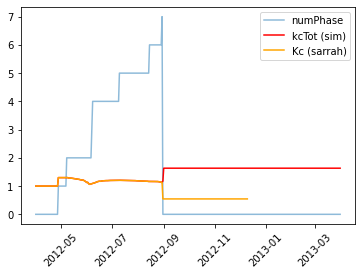

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


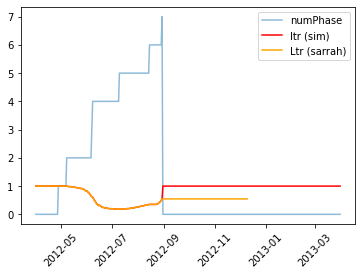

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


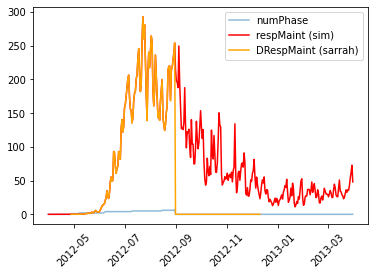

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


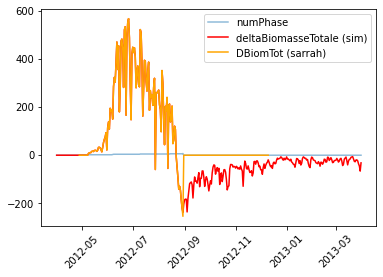

2012-08-15


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


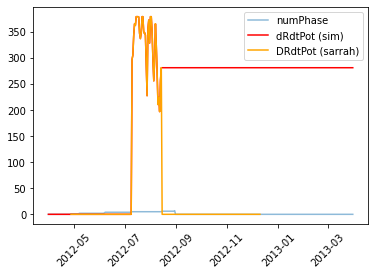

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


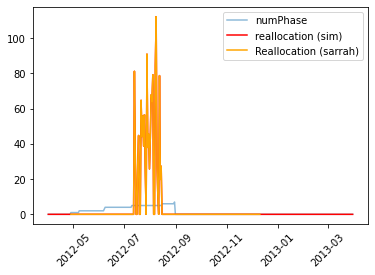

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


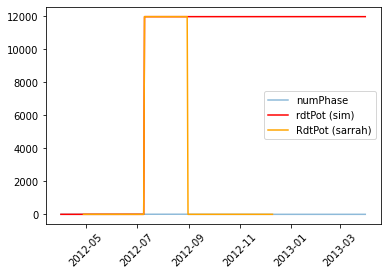

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


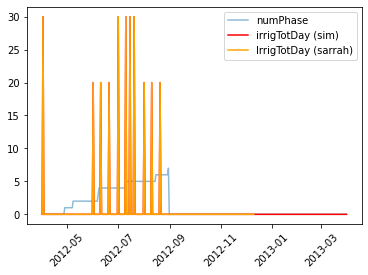

2012-08-30


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


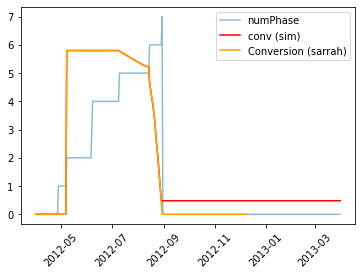

2012-08-31


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


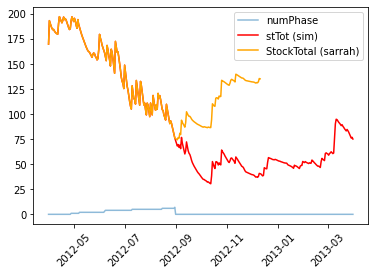

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


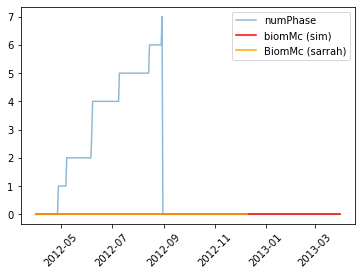

1990-01-01


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


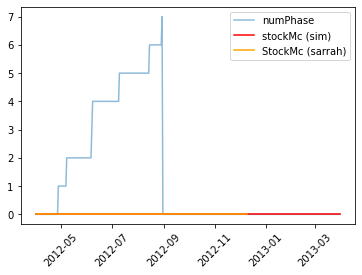

nan
nan
nan
nan
2012-09-05


/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_11207/1212108693.py:9: FutureWarning: The frame.append method is deprecated 

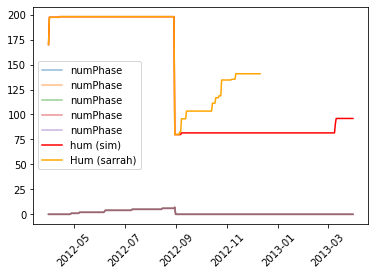

In [ ]:
diff = pd.DataFrame()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        
        date, meandiff = compute_earliest_diff(var, var_correspondance[var])
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
        try:
            graph_comparison(var, var_correspondance[var])
        except:
            pass
    except:
        print(var,'failed')
        pass

In [ ]:
diff.sort_values(by="earliest_diff")

,var,var2,earliest_diff,meandiff
0,Dr,dr,1990-01-01,4.482963e-16
0,StockMc,stockMc,1990-01-01,0.000000e+00
0,BiomMc,biomMc,1990-01-01,0.000000e+00
0,Lr,lr,1990-01-01,6.010066e-18
0,Eto,ET0,1990-01-01,0.000000e+00
0,VitesseRacinaire,vRac,1990-01-01,0.000000e+00
0,IrrigTotDay,irrigTotDay,1990-01-01,0.000000e+00
0,Reallocation,reallocation,1990-01-01,2.900861e-14
0,EauDispo,eauDispo,1990-01-01,1.398706e-17
0,Par,par,1990-01-01,0.000000e+00
